# Model Calibration with Epydemix

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ngozzi/tech-transfer-epdemix/blob/main/sessions/session-3/python/02_calibration_tutorial.ipynb)

This tutorial covers calibrating epidemic models to observed data using Approximate Bayesian Computation (ABC) methods.

**What you'll learn:**
- Set up calibration with prior distributions and distance functions
- Compare three ABC calibration strategies: ABC-SMC, ABC Rejection, and Top X%
- Visualize posterior distributions and calibration fits
- Run projections from calibrated models

In [1]:
# Colab installation (skip if running locally)
import sys, os, subprocess
if "google.colab" in sys.modules or os.getenv("COLAB_RELEASE_TAG"):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-r",
                    "https://raw.githubusercontent.com/epistorm/epydemix/refs/heads/main/tutorials/colab_requirements.txt"])

---
## 1. Loading and Exploring the Data

We'll calibrate an SIR model to synthetic incidence data (new infections per day) from Indonesia. The data was generated from an SIR model with known parameters, plus observation noise.

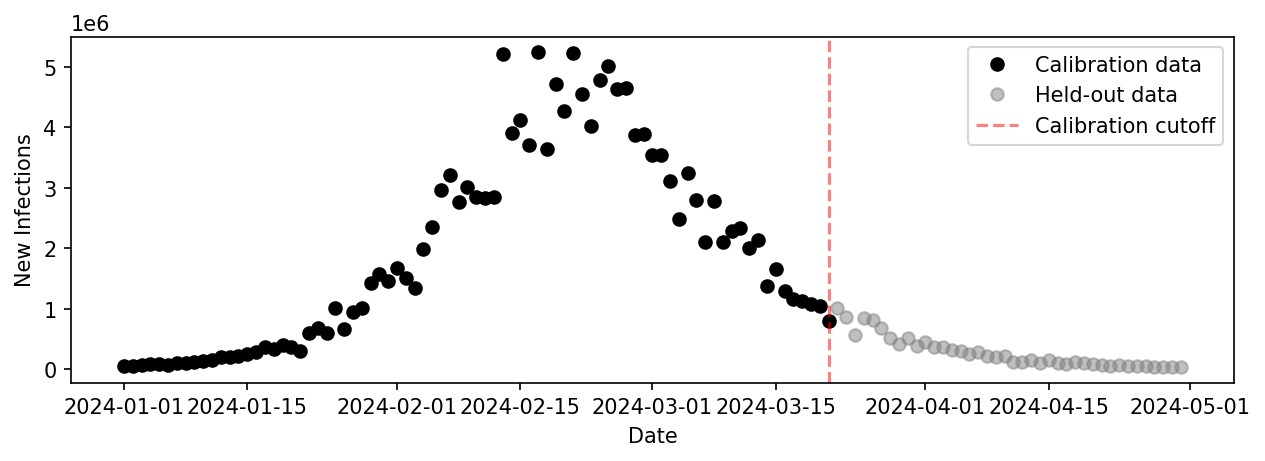

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load incidence data
data = pd.read_csv('https://raw.githubusercontent.com/epistorm/epydemix/refs/heads/main/tutorials/data/incidence_data.csv')
data["date"] = pd.to_datetime(data["date"])

# Split into calibration and projection periods
data_calibration = data.iloc[:-40]
data_projection = data.iloc[-40:]

# Plot the data
fig, ax = plt.subplots(dpi=150, figsize=(10, 3))
ax.plot(data_calibration["date"], data_calibration["data"], "ko", label="Calibration data")
ax.plot(data_projection["date"], data_projection["data"], "o", color="gray", alpha=0.5, label="Held-out data")
ax.axvline(data_calibration["date"].iloc[-1], color="red", linestyle="--", alpha=0.5, label="Calibration cutoff")
ax.set_xlabel("Date")
ax.set_ylabel("New Infections")
ax.legend()

---
## 2. Setting Up the Model

We'll use a predefined SIR model with Indonesia's population data.

In [3]:
from epydemix import load_predefined_model
from epydemix.utils import compute_simulation_dates

# Load predefined SIR model
model = load_predefined_model("SIR")
model.import_epydemix_population(population_name="Indonesia")
print(model)

EpiModel(name='EpiModel')
Compartments: 3
  Susceptible, Infected, Recovered
Transitions: 2
  Transitions between compartments:
    Susceptible -> Infected, params: ('transmission_rate', 'Infected') (kind: mediated)
    Infected -> Recovered, params: recovery_rate (kind: spontaneous)
Parameters: 2
  Model parameters:
    transmission_rate: 0.3
    recovery_rate: 0.1
Population: Indonesia
  Population size: 282353643 individuals
  Demographic groups: 5
    0-4, 5-19, 20-49, 50-64, 65+



In [4]:
# Initial conditions: 0.05% of population infected
initial_conditions = {
    "Susceptible": model.population.Nk - (model.population.Nk * 0.05 / 100).astype(int),
    "Infected": (model.population.Nk * 0.05 / 100).astype(int),
    "Recovered": np.zeros(len(model.population.Nk))
}

# Simulation parameters for calibration period
parameters = {
    "initial_conditions_dict": initial_conditions,
    "epimodel": model,
    "start_date": data_calibration.date.values[0],
    "end_date": data_calibration.date.values[-1]
}

# Compute simulation dates
simulation_dates_calibration = compute_simulation_dates(
    start_date=data_calibration.date.values[0],
    end_date=data_calibration.date.values[-1]
)
simulation_dates_projection = compute_simulation_dates(
    start_date=data_calibration.date.values[0],
    end_date=data_projection.date.values[-1]
)

---
## 3. Defining Priors and the Calibration Wrapper

### Prior Distributions

Prior distributions encode our beliefs about parameter values before seeing the data. We use `scipy.stats` distributions:

In [5]:
from scipy import stats

# Uniform priors for transmission and recovery rates
priors = {
    "transmission_rate": stats.uniform(0.010, 0.020),  # U(0.01, 0.03)
    "recovery_rate": stats.uniform(0.15, 0.1)          # U(0.15, 0.25)
}

### Simulation Wrapper Function

The `ABCSampler` requires a function that returns a dictionary with a `'data'` key containing the quantity to compare against observations. This wrapper extracts new infections (S→I transitions) from the simulation output:

In [6]:
from epydemix import simulate
from epydemix.calibration import ABCSampler, rmse

def simulate_wrapper(parameters):
    """Run simulation and extract incidence for calibration."""
    results = simulate(**parameters)
    return {"data": results.transitions["Susceptible_to_Infected_total"]}

# Initialize the ABC sampler
abc_sampler = ABCSampler(
    simulation_function=simulate_wrapper,
    priors=priors,
    parameters=parameters,
    observed_data=data_calibration["data"].values,
    distance_function=rmse  # Root Mean Squared Error
)

---
## 4. Running Calibration

Epydemix supports three calibration strategies:

| Method | Description | When to Use |
|--------|-------------|-------------|
| **ABC-SMC** | Sequential Monte Carlo with adaptive tolerance | Most accurate, recommended for final results |
| **ABC Rejection** | Simple accept/reject with fixed tolerance | Fast exploratory analysis |
| **Top X%** | Keep best fraction of simulations | Fixed runtime, good for prototyping |

Let's run all three and compare.

In [7]:
# ABC-SMC: 5 generations, 100 particles per generation
results_abc_smc = abc_sampler.calibrate(
    strategy="smc",
    num_particles=100,
    num_generations=5
)

Starting ABC-SMC with 100 particles and 5 generations

Generation 1/5 (epsilon: inf)
	Accepted 100/100 (acceptance rate: 100.00%)
	Elapsed time: 00:00:02

Generation 2/5 (epsilon: 2372197.929687)
	Accepted 100/181 (acceptance rate: 55.25%)
	Elapsed time: 00:00:05

Generation 3/5 (epsilon: 1320493.461689)
	Accepted 100/291 (acceptance rate: 34.36%)
	Elapsed time: 00:00:08

Generation 4/5 (epsilon: 739588.320501)
	Accepted 100/380 (acceptance rate: 26.32%)
	Elapsed time: 00:00:10

Generation 5/5 (epsilon: 530931.203146)
	Accepted 100/859 (acceptance rate: 11.64%)
	Elapsed time: 00:00:23


In [8]:
# ABC Rejection: fixed tolerance based on ABC-SMC final epsilon
results_abc_rejection = abc_sampler.calibrate(
    strategy="rejection",
    num_particles=100,
    epsilon=550000
)

Starting ABC rejection sampling with 100 particles and epsilon threshold 550000
	Simulations: 1000, Accepted: 33, Acceptance rate: 3.30%
	Simulations: 2000, Accepted: 86, Acceptance rate: 4.30%
	Final: 100 particles accepted from 2307 simulations (4.33% acceptance rate)


In [9]:
# Top X%: keep best 10% of 1000 simulations
results_top_perc = abc_sampler.calibrate(
    strategy="top_fraction",
    Nsim=1000,
    top_fraction=0.1
)

Starting ABC top fraction selection with 1000 simulations and top 10.0% selected
	Progress: 100/1000 simulations completed (10.0%)
	Progress: 200/1000 simulations completed (20.0%)
	Progress: 300/1000 simulations completed (30.0%)
	Progress: 400/1000 simulations completed (40.0%)
	Progress: 500/1000 simulations completed (50.0%)
	Progress: 600/1000 simulations completed (60.0%)
	Progress: 700/1000 simulations completed (70.0%)
	Progress: 800/1000 simulations completed (80.0%)
	Progress: 900/1000 simulations completed (90.0%)
	Progress: 1000/1000 simulations completed (100.0%)
	Selected 100 particles (top 10.0%) with distance threshold 758074.143871


---
## 5. Comparing Calibration Results

### Calibration Fits

Let's visualize how well each method fits the observed data:

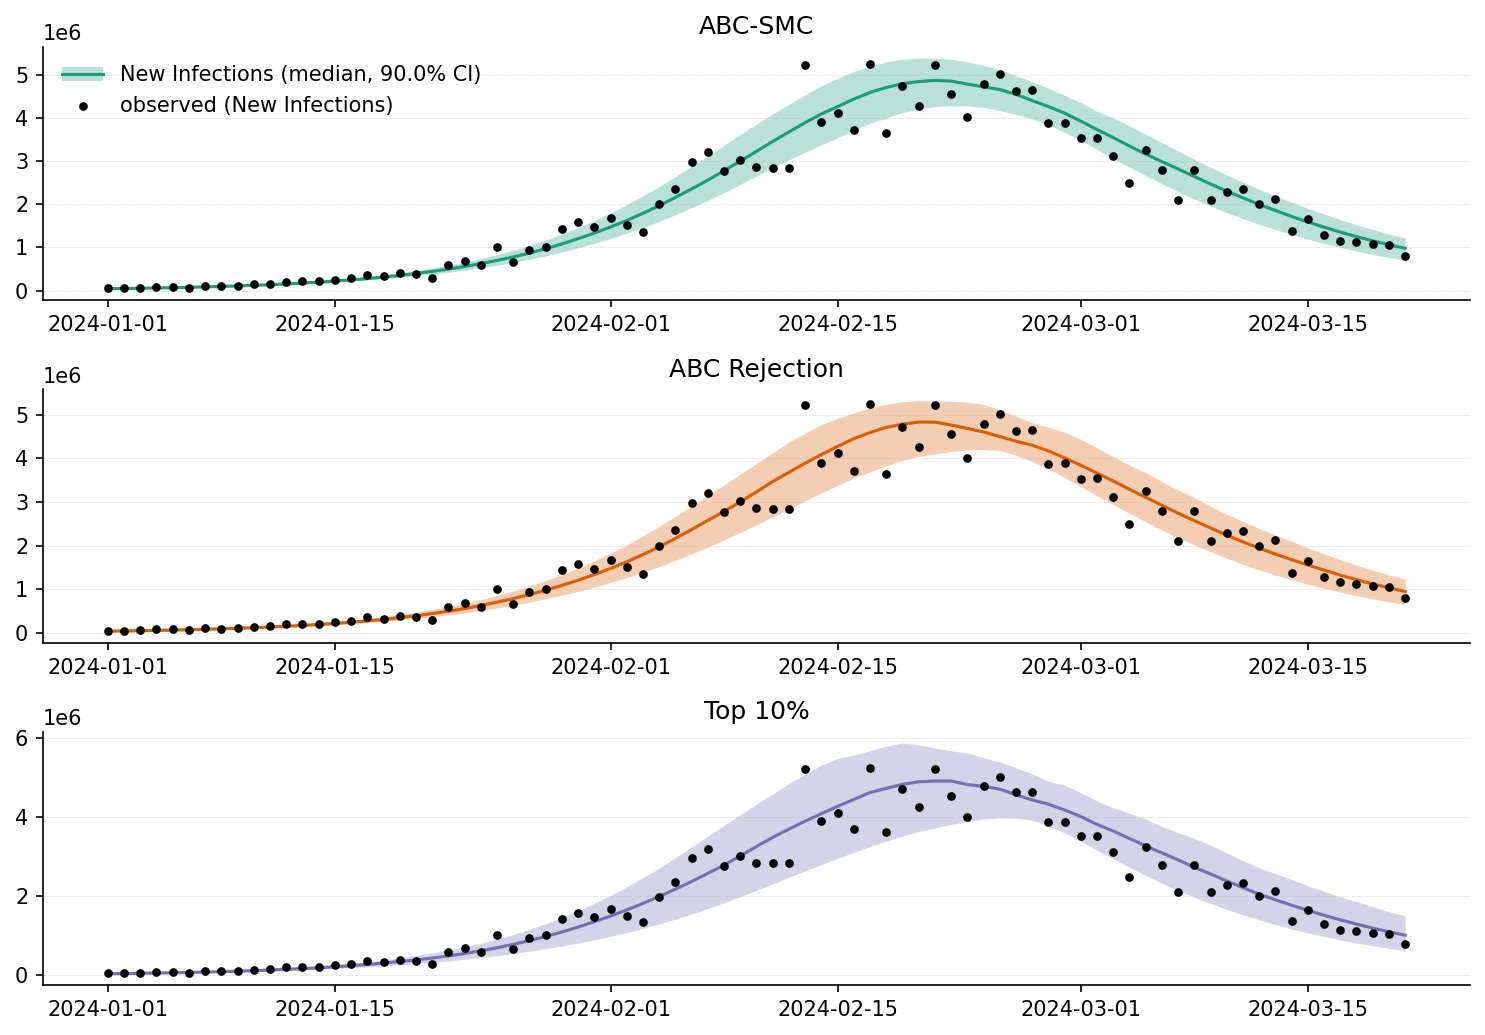

In [10]:
from epydemix.visualization import plot_quantiles
import seaborn as sns

colors = sns.color_palette("Dark2")

# Compute quantiles for each method
df_quantiles_smc = results_abc_smc.get_calibration_quantiles(dates=simulation_dates_calibration)
df_quantiles_rejection = results_abc_rejection.get_calibration_quantiles(dates=simulation_dates_calibration)
df_quantiles_top = results_top_perc.get_calibration_quantiles(dates=simulation_dates_calibration)

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(10, 7), dpi=150)

plot_quantiles(df_quantiles_smc, columns="data", data=data_calibration, ax=axes[0],
               title="ABC-SMC", colors=colors[0], show_data=True, labels=["New Infections"])

plot_quantiles(df_quantiles_rejection, columns="data", data=data_calibration, ax=axes[1],
               title="ABC Rejection", colors=colors[1], show_data=True, show_legend=False)

plot_quantiles(df_quantiles_top, columns="data", data=data_calibration, ax=axes[2],
               title="Top 10%", colors=colors[2], show_data=True, show_legend=False)

plt.tight_layout()

### Posterior Distributions

The posterior distribution shows our updated beliefs about parameter values after seeing the data. Let's compare the 2D joint posteriors:

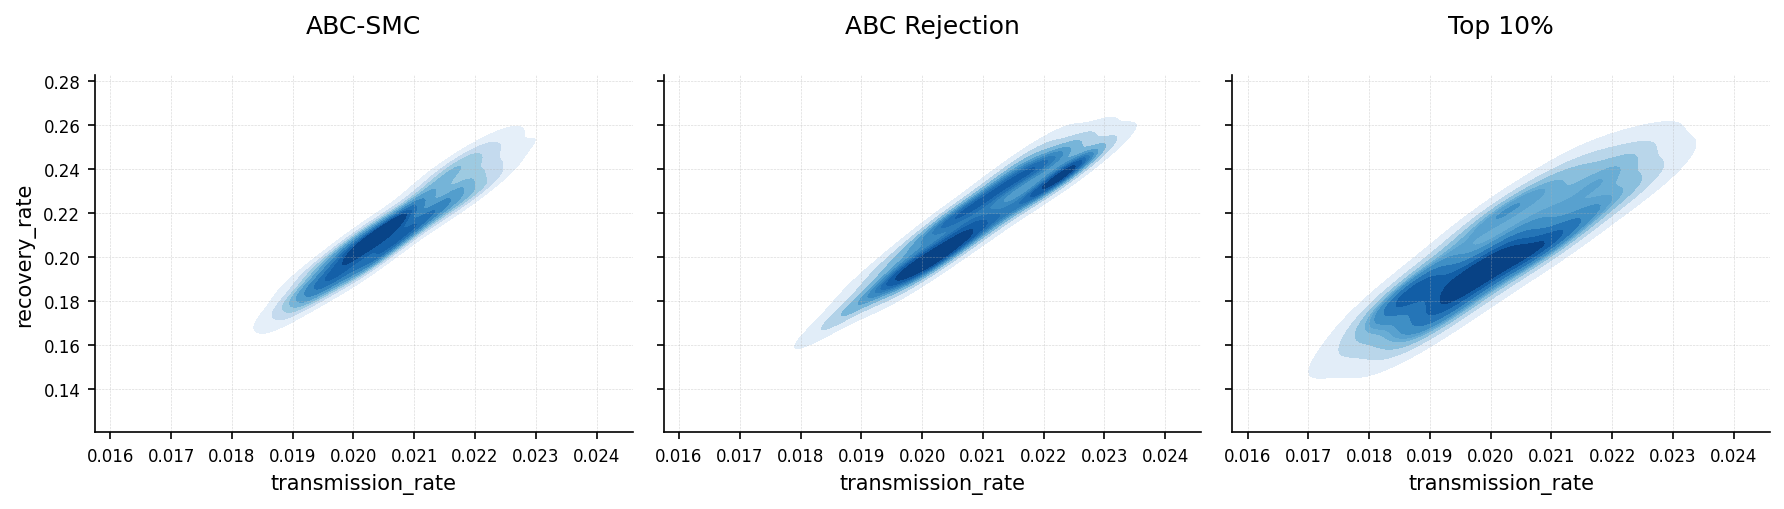

In [11]:
from epydemix.visualization import plot_posterior_distribution_2d

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), dpi=150, sharex=True, sharey=True)

plot_posterior_distribution_2d(results_abc_smc.get_posterior_distribution(),
                               "transmission_rate", "recovery_rate",
                               ax=axes[0], kind="kde", title="ABC-SMC", prior_range=False)

plot_posterior_distribution_2d(results_abc_rejection.get_posterior_distribution(),
                               "transmission_rate", "recovery_rate",
                               ax=axes[1], kind="kde", title="ABC Rejection", prior_range=False)

plot_posterior_distribution_2d(results_top_perc.get_posterior_distribution(),
                               "transmission_rate", "recovery_rate",
                               ax=axes[2], kind="kde", title="Top 10%", prior_range=False)

plt.tight_layout()

We can also examine the marginal posterior distributions for each parameter:

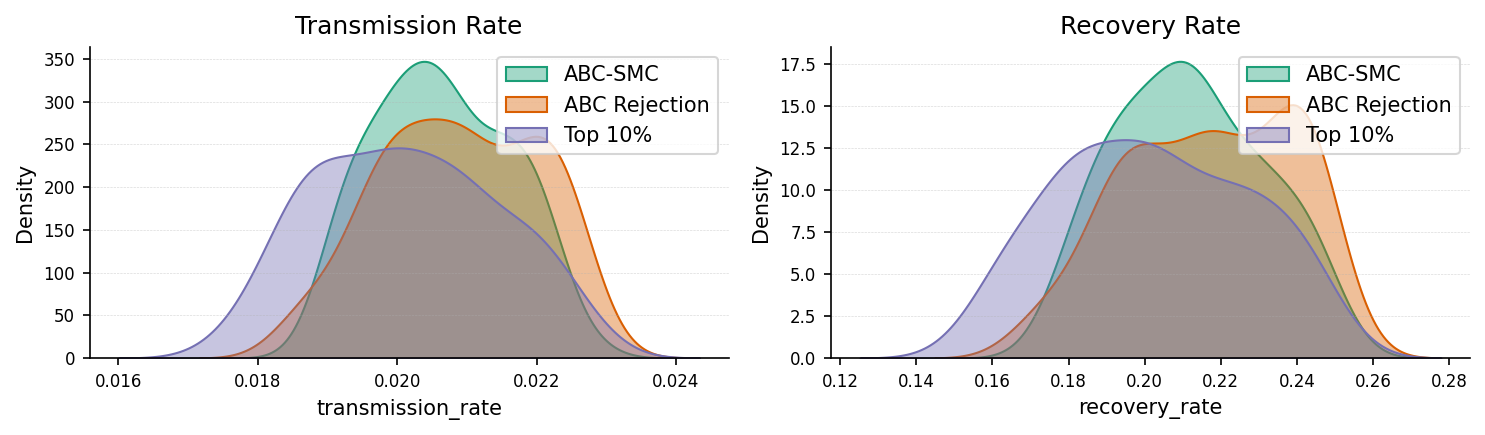

In [12]:
from epydemix.visualization import plot_posterior_distribution

fig, axes = plt.subplots(1, 2, figsize=(10, 3), dpi=150)

# Transmission rate
for results, color, label in [(results_abc_smc, colors[0], "ABC-SMC"),
                               (results_abc_rejection, colors[1], "ABC Rejection"),
                               (results_top_perc, colors[2], "Top 10%")]:
    plot_posterior_distribution(results.get_posterior_distribution(), "transmission_rate",
                                ax=axes[0], kind="kde", color=color, label=label, prior_range=False)

axes[0].set_title("Transmission Rate")
axes[0].legend()

# Recovery rate
for results, color, label in [(results_abc_smc, colors[0], "ABC-SMC"),
                               (results_abc_rejection, colors[1], "ABC Rejection"),
                               (results_top_perc, colors[2], "Top 10%")]:
    plot_posterior_distribution(results.get_posterior_distribution(), "recovery_rate",
                                ax=axes[1], kind="kde", color=color, label=label, prior_range=False)

axes[1].set_title("Recovery Rate")
axes[1].legend()

plt.tight_layout()

### Distance Distributions

The distribution of distances (RMSE) for accepted particles shows how well each method concentrates on good-fitting parameters:

Text(0.5, 1.0, 'Distribution of Distances for Accepted Particles')

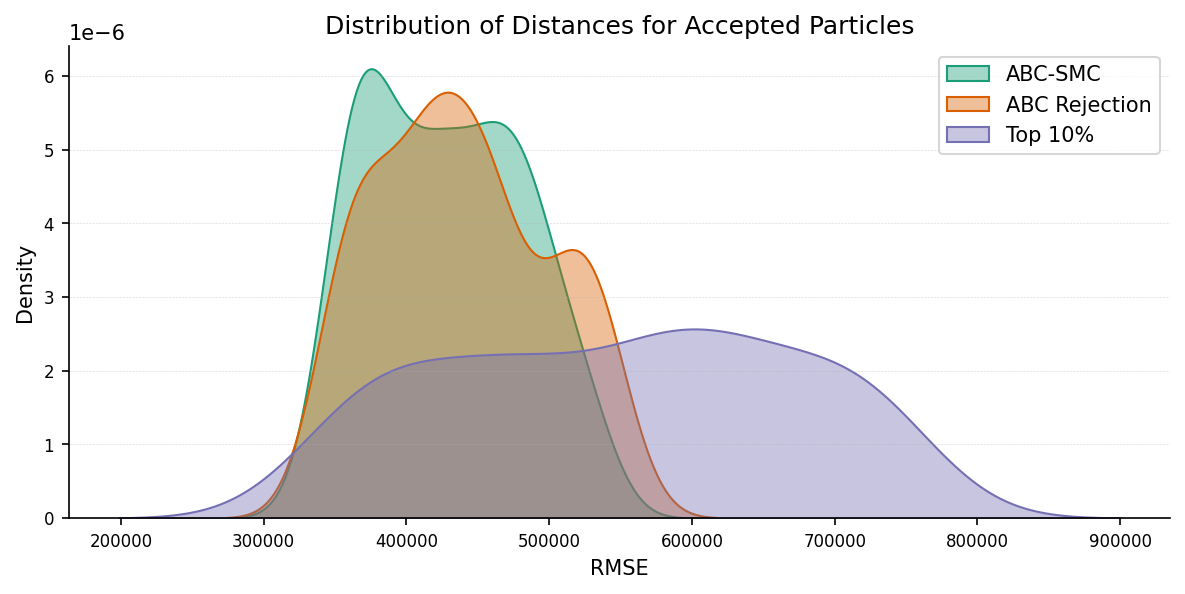

In [13]:
from epydemix.visualization import plot_distance_distribution

fig, ax = plt.subplots(figsize=(8, 4), dpi=150)

plot_distance_distribution(results_abc_smc.get_distances(), ax=ax, kind="kde",
                           color=colors[0], label="ABC-SMC", xlabel="RMSE")
plot_distance_distribution(results_abc_rejection.get_distances(), ax=ax, kind="kde",
                           color=colors[1], label="ABC Rejection", xlabel="RMSE")
plot_distance_distribution(results_top_perc.get_distances(), ax=ax, kind="kde",
                           color=colors[2], label="Top 10%", xlabel="RMSE")

ax.legend()
ax.set_title("Distribution of Distances for Accepted Particles")

---
## 6. Running Projections

After calibrating the model, we can project the epidemic forward in time. The `run_projections` method uses the posterior parameter samples to generate future trajectories with uncertainty quantification.

In [14]:
# Create projection parameters (extend end date)
projection_parameters = parameters.copy()
projection_parameters["end_date"] = data_projection.date.values[-1]

# Run projections using the calibrated posterior
results_with_projections = abc_sampler.run_projections(projection_parameters)

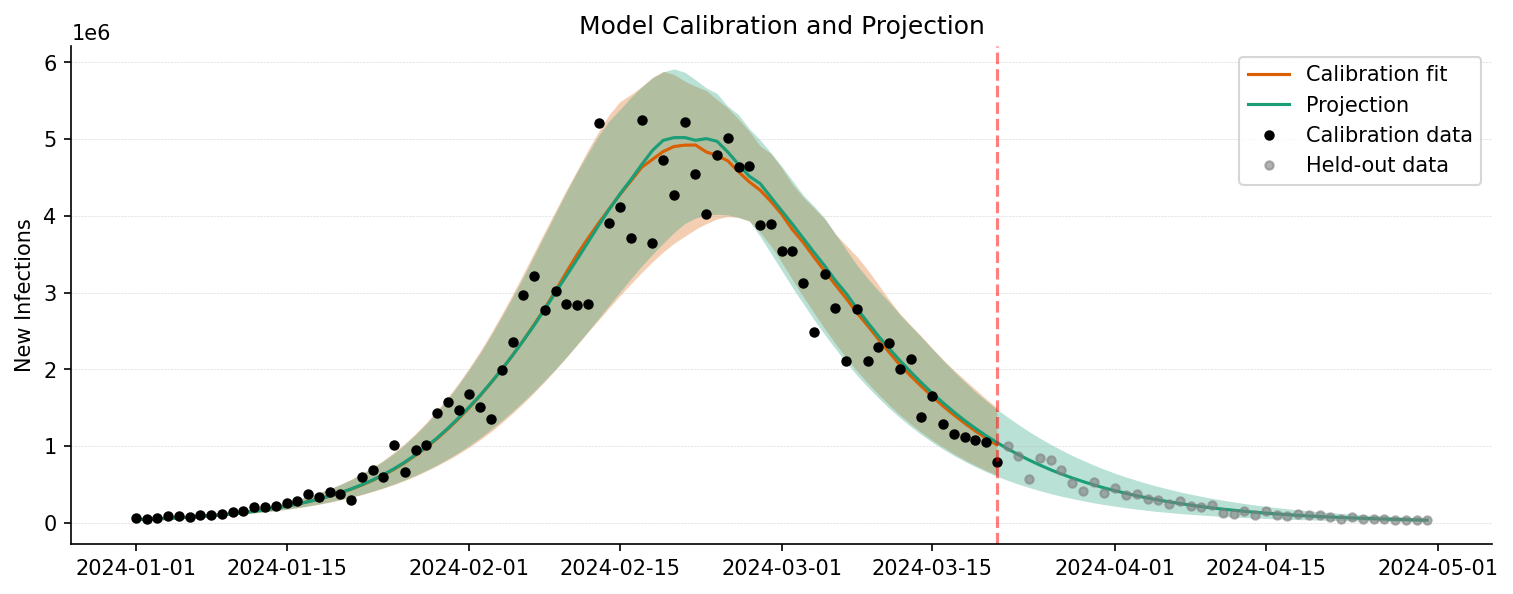

In [15]:
# Get quantiles for calibration and projection periods
df_calibration = results_with_projections.get_calibration_quantiles(simulation_dates_calibration)
df_projection = results_with_projections.get_projection_quantiles(simulation_dates_projection)

# Plot results
fig, ax = plt.subplots(dpi=150, figsize=(10, 4))

# Calibration fit
plot_quantiles(df_calibration, columns="data", ax=ax,
               colors=colors[1], show_data=False, labels=["Calibration fit"])

# Projection
plot_quantiles(df_projection, columns="data", ax=ax,
               colors=colors[0], show_data=False, labels=["Projection"])

# Observed data
ax.plot(data_calibration["date"], data_calibration["data"], "ko", markersize=4, label="Calibration data")
ax.plot(data_projection["date"], data_projection["data"], "o", color="gray", 
        markersize=4, alpha=0.6, label="Held-out data")

# Mark the calibration cutoff
ax.axvline(data_calibration["date"].iloc[-1], color="red", linestyle="--", alpha=0.5)

ax.set_ylabel("New Infections")
ax.set_title("Model Calibration and Projection")
ax.legend(loc="upper right")

---
## Resources

- [Epydemix Documentation](https://epydemix.readthedocs.io/)
- [ABC Methods Reference (Minter et al., 2019)](https://www.sciencedirect.com/science/article/pii/S175543651930026X)
- [ABC-SMC Algorithm (Toni et al., 2009)](https://pubmed.ncbi.nlm.nih.gov/19205079)